# Phenotyping Censored Survival Data
<hr>

Author: ***Willa Potosnak***  &lt;wpotosna@andrew.cmu.edu&gt;

<div style=" float: right;">
<img align="right" src="https://ndownloader.figshare.com/files/34052981" width="25%"/>
<img align="right" src="https://www.cs.cmu.edu/~chiragn/auton_logo.png" width="25%"/>
</div>


<a id="intro"></a>

## 1. Introduction

`auton-survival` 提供表型分析（或分组）工具，用于评估不同组之间的生存概率差异。表型分析可帮助临床决策者洞察哪些患者群体存在生存概率差异，从而影响针对这些群体的临床实践。
   * <b>交叉表型分析</b> 
       - 从用户指定的所有类别和数值特征组合中识别样本表型。
   * <b>无监督表型分析</b>
       - 基于特征空间中的相似性对样本进行分组，识别表型。
   * <b>有监督表型分析</b>
       - 识别具有相似生存结局的潜在个体群体。 
   * <b>反事实表型分析</b>
       - 识别对干预表现出异质性效应的潜在表型。


<a id="support"></a>

### 1.1. The SUPPORT Dataset

*原始数据源请参考以下[网站](https://biostat.app.vumc.org/wiki/Main/SupportDesc)。*
数据特征 $\mathbf{x}$ 存储在一个 pandas DataFrame 中，其中行对应单个样本，列对应协变量。数据结果包含“时间”$\mathbf{t}$ 和“事件”$\mathbf{e}$，分别对应事件发生时间和删失指示符。

In [1]:
# 导入并执行修复（只需运行一次）
import compatibility_solution
print("✅ matplotlib 修复完成，全局生效！")

d:\Analysis\Anaconda3\envs\auton_survival\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ matplotlib 修复完成，全局生效！


In [2]:
# 导入 pandas 库，用于数据处理与分析（如 DataFrame 操作）
import pandas as pd

# 导入 sys 模块，用于访问与 Python 解释器相关的变量和函数
import sys

# 将上级目录（'../'）添加到 Python 模块搜索路径，方便导入自定义模块
sys.path.append('../')

# 从 auton_survival 包的 datasets 子模块中导入 load_dataset 函数，用于加载生存分析数据集
from auton_survival.datasets import load_dataset

<a id="preprocess"></a>
### 1.2. Preprocessing the Data

In [3]:
# 调用 load_dataset 函数，加载名为 'SUPPORT' 的数据集，返回两个对象：
# outcomes: 目标变量（如生存状态等）
# features: 特征变量（患者各项指标）
outcomes, features = load_dataset(dataset='SUPPORT')
# 将特征变量按数据类型分为两类：
# cat_feats: 分类特征列表，共 6 个，均为离散型变量
cat_feats = ['sex', 'dzgroup', 'dzclass', 'income', 'race', 'ca']
# num_feats: 连续特征列表，共 18 个，均为数值型变量
num_feats = ['age', 'num.co', 'meanbp', 'wblc', 'hrt', 'resp', 
             'temp', 'pafi', 'alb', 'bili', 'crea', 'sod', 'ph', 
             'glucose', 'bun', 'urine', 'adlp', 'adls']
# 使用 display 函数展示 features 的前
# Let's take a look at the outcomes
display(outcomes.head(5))

,event,time
0,0,2029
1,1,4
2,1,47
3,1,133
4,0,2029


在这里我们对整个数据集执行插补和缩放，但在实践中我们建议仅对训练数据拟合预处理工具。


In [4]:
# 从 auton_survival 库中导入用于数据预处理的 Preprocessor 类
from auton_survival.preprocessing import Preprocessor

# 实例化 Preprocessor，指定：
#   cat_feat_strat='ignore'  -> 对缺失的分类特征直接忽略（不做处理）
#   num_feat_strat='mean'    -> 对缺失的数值特征用该列均值填充
preprocessor = Preprocessor(cat_feat_strat='ignore', num_feat_strat='mean') 

# 调用 fit_transform 对原始特征进行预处理：
#   features     : 原始特征 DataFrame
#   cat_feats    : 分类特征列名列表
#   num_feats    : 数值特征列名列表
#   one_hot=True : 对分类特征进行独热编码
#   fill_value=-1: 其他缺失值统一用 -1 填充
# 返回处理后的特征矩阵 x
x = preprocessor.fit_transform(features, cat_feats=cat_feats, num_feats=num_feats,
                                one_hot=True, fill_value=-1)

In [5]:
import numpy as np                      # 导入 NumPy 库，用于高效的数组/矩阵运算
from sklearn.model_selection import train_test_split  # 从 sklearn 中导入 train_test_split 函数，用于划分训练集与测试集

# 将原始数据 x（特征）和 outcomes（标签）按 8:2 比例划分为训练集与测试集
# test_size=0.2 表示测试集占 20%，random_state=1 保证每次划分结果可复现
x_tr, x_te, y_tr, y_te = train_test_split(x, outcomes, test_size=0.2, random_state=1)

# 打印训练集样本数量，len(x_tr) 返回训练集的行数
print(f'Number of training data points: {len(x_tr)}')

# 打印测试集样本数量，len(x_te) 返回测试集的行数
print(f'Number of test data points: {len(x_te)}')

Number of training data points: 7284
Number of test data points: 1821


In [6]:
features.head()

,sex,dzgroup,dzclass,income,race,ca,age,num.co,meanbp,wblc,...,alb,bili,crea,sod,ph,glucose,bun,urine,adlp,adls
0,male,Lung Cancer,Cancer,$11-$25k,other,metastatic,62.84998,0,97.0,6.000000,...,1.799805,0.199982,1.199951,141.0,7.459961,NaN,NaN,NaN,7.0,7.0
1,female,Cirrhosis,COPD/CHF/Cirrhosis,$11-$25k,white,no,60.33899,2,43.0,17.097656,...,NaN,NaN,5.500000,132.0,7.250000,NaN,NaN,NaN,NaN,1.0
2,female,Cirrhosis,COPD/CHF/Cirrhosis,under $11k,white,no,52.74698,2,70.0,8.500000,...,NaN,2.199707,2.000000,134.0,7.459961,NaN,NaN,NaN,1.0,0.0
3,female,Lung Cancer,Cancer,under $11k,white,metastatic,42.38498,2,75.0,9.099609,...,NaN,NaN,0.799927,139.0,NaN,NaN,NaN,NaN,0.0,0.0
4,female,ARF/MOSF w/Sepsis,ARF/MOSF,NaN,white,no,79.88495,1,59.0,13.500000,...,NaN,NaN,0.799927,143.0,7.509766,NaN,NaN,NaN,NaN,2.0


<a id="interpheno"></a>
## 2. Intersectional Phenotyping
### 2. 交叉表型分析


交集表型分析器对用户指定的类别变量和数值变量集合执行穷举笛卡尔积，以获得表型。数值变量根据用户指定的分位数进行分箱。


<a id="fitinter"></a>
### 2.1. Fitting the Intersectional Phenotyper

在这里，我们在整个数据集上拟合了表型分析器，但在实践中，我们建议仅在训练数据上拟合表型分析器。


In [7]:
# 从 auton_survival 库中导入 IntersectionalPhenotyper 类，用于根据多个变量交叉划分样本亚型
from auton_survival.phenotyping import IntersectionalPhenotyper

# 定义年龄分箱的三分位点：0、0.5、1.0，即把年龄按中位数分成“低”和“高”两组
quantiles = (0, .5, 1.0)

# 实例化交叉亚型划分器：
# cat_vars=['ca'] 表示把“癌症状态(ca)”作为分类变量，不同取值分别成组
# num_vars=['age'] 表示把“年龄(age)”作为数值变量，按上面定义的 quantiles 分箱
# num_vars_quantiles 指定数值变量的分箱方式
# random_seed=0 保证每次运行结果可复现
phenotyper = IntersectionalPhenotyper(cat_vars=['ca'], num_vars=['age'],
                                      num_vars_quantiles=quantiles, random_seed=0)

# 在特征矩阵 features 上拟合并预测：先学习分箱规则，再为每条样本生成交叉亚型标签
phenotypes = phenotyper.fit_predict(features)

# 查看每个样本最终所属的交叉亚型标签（如 ca=0 & age低、ca=0 & age高、ca=1 & age低、ca=1 & age高）
phenotypes


array(['ca:metastatic & age:(18.041, 64.857]',
       'ca:no & age:(18.041, 64.857]', 'ca:no & age:(18.041, 64.857]',
       ..., 'ca:no & age:(64.857, 101.848]',
       'ca:yes & age:(18.041, 64.857]', 'ca:no & age:(64.857, 101.848]'],
      dtype='<U37')

<a id="plotpheno"></a>
### 2.2. Plotting Survival Curves

In [11]:
#####################################
### 解决 matplotlib.legend.Legend 类缺少 legendHandles 属性的问题####
#####################################
# 导入 matplotlib 库
import matplotlib

# 检查 matplotlib.legend.Legend 类是否缺少 legendHandles 属性
# 这样做是为了让代码更健壮，避免在已经存在该属性的旧版本上执行时可能引发问题
if not hasattr(matplotlib.legend.Legend, 'legendHandles'):
    
    # 为 Legend 类动态添加一个名为 legendHandles 的属性
    # 新版本的 matplotlib 使用 'legend_handles' 来存储图例句柄
    # 我们使用 property() 函数创建一个别名，当代码访问 legendHandles 时，
    # 它会被自动重定向去获取 legend_handles 的值。
    # 这样，依赖旧属性名的 pandas 代码就能在新版 matplotlib 上正常工作。
    matplotlib.legend.Legend.legendHandles = property(lambda self: self.legend_handles)

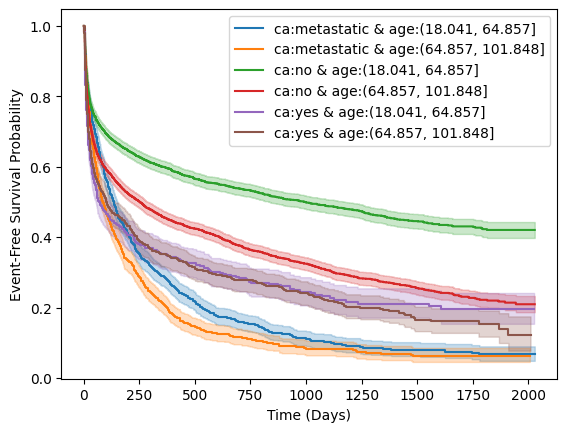

In [12]:
from auton_survival import reporting
import matplotlib.pyplot as plt

# Estimate the probability of event-free survival for phenotypes using the Kaplan Meier estimator.
reporting.plot_kaplanmeier(outcomes, phenotypes)

plt.xlabel('Time (Days)')
plt.ylabel('Event-Free Survival Probability')
plt.legend(loc="upper right")
plt.show()

如你所见，18 至 64 岁且无癌症的患者生存率最高；相反，64 至 101 岁且患有转移性癌症的患者生存率最低。


<a id="clusterpheno"></a>
## 3. Unsupervised Phenotyping

对输入协变量 $\mathbf{x}$ 进行降维，随后进行聚类。学到的聚类被视为表型，并用于根据协变量空间中的相似性对样本进行分组。样本与聚类关联的估计概率计算为样本到某一聚类中心的距离，再除以到其他所有聚类中心的距离之和。

\begin{align}
\mathbf{P}(Z=k | X=\mathbf{x}_i) = \frac{\mathbf{d}(x_i, x_c)}{\sum_{j=1}^{K} \mathbf{d}(x_i, x_j)}
\end{align}

其中 $d_i$ 表示到聚类 $k$ 的距离，$i \in \{1, 2, ..., n\}$ 且 $i \neq c$。


<a id="fitcluster"></a>
### 3.1. Fitting the Clustering Phenotyper

In [ ]:
# 导入用于聚类分型的 ClusteringPhenotyper 类
from auton_survival.phenotyping import ClusteringPhenotyper

# 设置降维方法为 PCA（主成分分析），用于减少特征维度
dim_red_method = 'pca' 
# 设置聚类方法为 GMM（高斯混合模型），并采用对角协方差矩阵
clustering_method = 'gmm'
# 指定 PCA 降维后的主成分数量
n_components = 8 
# 指定聚类簇数，即期望得到的表型数量
n_clusters = 2 # Number of underlying phenotypes

# 初始化 ClusteringPhenotyper，传入降维方法、聚类方法、主成分数和簇数
phenotyper = ClusteringPhenotyper(clustering_method=clustering_method, 
                                              dim_red_method=dim_red_method, 
                                              n_components=n_components, 
                                              n_clusters=n_clusters)
# 对训练数据 x_tr 进行拟合并预测每个样本所属的表型簇
phenotypes = phenotyper.fit_predict(x_tr)

# 查看生成的表型标签
phenotypes

Fitting the following Dimensionality Reduction Model:
 PCA(n_components=8, random_state=0)
Fitting the following Clustering Model:
 GaussianMixture(covariance_type='diag', n_components=3, random_state=0)


array([1, 2, 1, ..., 1, 1, 2], dtype=int64)

<a id="clusterplot"></a>
### 3.2. Plotting Survival Curves

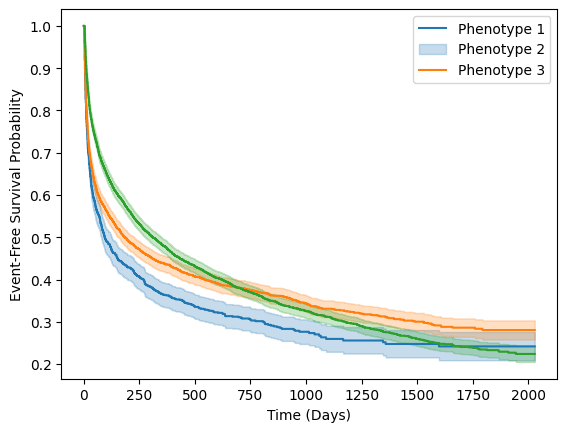

In [ ]:
from auton_survival import reporting  # 导入 auton_survival 中的 reporting 模块，用于生存分析可视化
import matplotlib.pyplot as plt      # 导入 matplotlib 的 pyplot 子模块，用于绘图

# 使用 Kaplan-Meier 估计器绘制不同表型（phenotypes）的无事件生存概率曲线
# outcomes.loc[x_tr.index] 选取与训练集索引对应的生存结局数据；phenotypes 是表型分组标签
reporting.plot_kaplanmeier(outcomes.loc[x_tr.index], phenotypes)

# 设置 x 轴标签为“时间（天）”
plt.xlabel('Time (Days)')
# 设置 y 轴标签为“无事件生存概率”
plt.ylabel('Event-Free Survival Probability')
# 再次设置 x 轴标签（与上一行重复，可删除）
plt.xlabel('Time (Days)')
# 添加图例，对应三种表型，位置在右上角
plt.legend(['Phenotype 1', 'Phenotype 2', 'Phenotype 3'], loc="upper right")
# 显示绘制好的生存曲线图
plt.show()

相交的生存率表明 SUPPORT 数据集存在非比例风险，这违反了 Cox 模型的假设。


<a id="clusterphenopur"></a>
### 3.3. Evaluating Phenotype Purity

为了衡量一个表型分析器提取具有不同生存率的亚群的能力，我们在每个表型组内拟合Kaplan-Meier估计器，并利用其估计每个表型组内的生存率，从而估算（综合）Brier评分。我们将此称为*表型纯度*。


In [12]:
# 从 auton_survival 包中导入 phenotype_purity 函数，用于计算表型纯度
from auton_survival.metrics import phenotype_purity

# 调用 phenotype_purity 函数，基于训练集表型与结局，计算在 1 年、2 年、5 年（对应 365、730、1825 天）事件时间点的表型纯度
# 参数说明：
#   phenotypes_train: 训练集的表型标签（如聚类结果）
#   outcomes_train: 训练集的真实结局（如生存事件）
#   phenotypes_test/outcomes_test: 测试集数据，此处为 None，表示仅使用训练集评估
#   strategy='instantaneous': 采用瞬时策略，即在每个 horizon 时间点单独计算
#   horizons: 以天为单位的事件时间点列表
#   bootstrap=None: 不使用自助法重采样
metric = phenotype_purity(phenotypes_train=phenotypes, outcomes_train=y_tr,
                          phenotypes_test=None, outcomes_test=None,
                          strategy='instantaneous', horizons=[365, 730, 1825],
                          bootstrap=None)

# 打印各事件时间点的表型纯度值，metric 返回的是一个数组，依次对应 1 年、2 年、5 年的结果
print(f'Phenotyping purity for event horizon of 1 year: {metric[0]} | 2 years: {metric[1]} | 5 years: {metric[2]}')

Phenotyping purity for event horizon of 1 year: 0.2455368004986801 | 2 years: 0.23061501456202 | 5 years: 0.18646535424261926


d:\Analysis\Anaconda3\envs\auton_survival\lib\site-packages\auton_survival\metrics.py:334: UserWarning: You are are estimating survival probabilities for the same dataset used to estimate the censoring distribution.
  warnings.warn("You are are estimating survival probabilities for \
d:\Analysis\Anaconda3\envs\auton_survival\lib\site-packages\lifelines\fitters\__init__.py:204: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
d:\Analysis\Anaconda3\envs\auton_survival\lib\site-packages\lifelines\fitters\__init__.py:204: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
d:\Analysis\Anaconda3\envs\auton_survival\lib\site-packages\lifelines\fitters\__init__.py:204: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using l

<a id="DCM"></a>
## 4. Supervised Phenotyping with Deep Cox Mixtures (DCM)

<a id="dcm"></a>

与无监督聚类不同，推断监督表型需要事件发生时间、相应的删失指示符以及协变量。`auton-survival` 提供了在训练 Deep Survival Machines (DSM) 和 Deep Cox Mixtures (DCM) 潜变量生存回归估计器后进行监督表型分析的实用工具。请注意，DSM 恢复的是具有相似参数特征的表型，而 DCM 恢复的是遵循比例风险假设的表型。

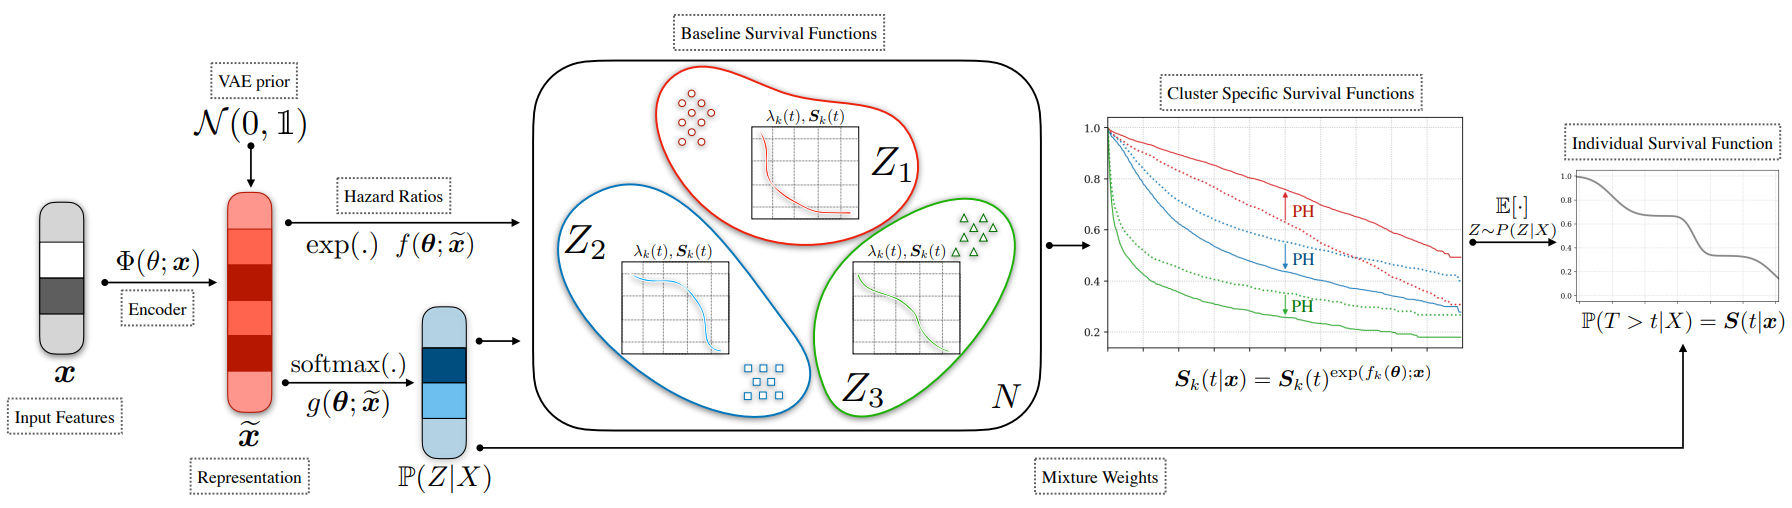

<b>图 A：</b> DCM 通过编码神经网络生成个体协变量 $x$ 的表示。输出表示 $xe$ 随后与线性函数 $f$ 和 $g$ 交互，分别确定每个聚类 $Z ∈ {1, 2, ...K}$ 内的比例风险以及混合权重 $P(Z|X)$。对于每个聚类，基线生存率 $Sk(t)$ 以非参数方式估计。最终的个体生存曲线 $S(t|x)$ 是对各聚类特定个体生存曲线按混合概率 $P(Z|X = x)$ 加权后的平均值。


*有关 Deep Cox Mixtures (DCM) 的完整细节，请参阅以下论文*：

[2] [Nagpal, C., Yadlowsky, S., Rostamzadeh, N., and Heller, K. (2021c). Deep cox mixtures for survival regression. In
Machine Learning for Healthcare Conference, pages 674–708. PMLR.](https://arxiv.org/abs/2101.06536)

<a id="fitDCM"></a>
### 4.1. Fitting the DCM Model

将 DCM 模型拟合到训练数据。通过选择使验证集上计算的 Brier 分数最小化的模型参数来执行超参数调优。
$\textbf{Brier 分数} \ (\textrm{BS})$：定义为在某一时间范围内对概率预测的均方误差（MSE）。
\begin{align}
\text{BS}(t) = \mathop{\mathbf{E}}_{x\sim\mathcal{D}}\big[ ||\mathbf{1}\{ T > t \} - \widehat{\mathbf{P}}(T>t|X)\big)||_{_\textbf{2}}^\textbf{2}  \big]
\end{align}

In [13]:
# 从 auton_survival 库中导入 DeepCoxMixtures 模型，用于深度生存分析
from auton_survival.models.dcm import DeepCoxMixtures
# 导入 ParameterGrid，用于生成参数网格，便于网格搜索
from sklearn.model_selection import ParameterGrid
# 导入 brier_score，用于评估生存模型的预测性能（虽然此处未使用）
from sksurv.metrics import brier_score

# 定义超参数网格：这里只尝试一组参数，k 为聚类数，learning_rate 为学习率，layers 为网络层结构
param_grid = {'k' : [3],
              'learning_rate' : [1e-3],
              'layers' : [[100]]
             }

# 使用 ParameterGrid 将参数网格展开为可迭代的参数组合列表
params = ParameterGrid(param_grid)

# 遍历每一组参数组合
for param in params:
    # 实例化 DeepCoxMixtures 模型，传入当前参数：聚类数 k、网络层结构 layers，并固定随机种子保证可复现
    model = DeepCoxMixtures(k = param['k'],
                            layers = param['layers'],
                            random_seed=0)
    
# 使用 fit 方法训练模型：传入特征数据 x_tr、生存时间 y_tr.time、事件指示 y_tr.event，
# 设置迭代次数 iters=100，学习率使用循环中最后一组参数的 learning_rate
model.fit(x_tr, y_tr.time, y_tr.event, iters = 100, learning_rate = param['learning_rate'])

 70%|███████   | 70/100 [00:49<00:21,  1.41it/s]


<a id="latentz"></a>
### 4.2. Inferring latent Phenotypes

混合概率 $P(Z|X = x)$ 通过编码器门控函数 $g(.)$ 估计个体样本与潜在表型的关联。$P(Z|X = x)$ 用于对聚类特异性的个体生存曲线进行加权，以计算最终的个体生存曲线 $S(t|x)$。


In [14]:
# 从 auton_survival 的 dcm 模块中导入用于预测潜在变量 z 的函数
from auton_survival.models.dcm.dcm_utilities import predict_latent_z

# 使用训练好的模型对训练集 x_tr 进行潜在变量 z 的概率预测
# 返回的是每个样本属于各个潜在类别的概率矩阵
latent_z_prob = model.predict_latent_z(x_tr.values)

# 查看潜在类别的概率分布（每个样本属于各个潜在组的概率）
latent_z_prob


array([[0.09652437, 0.8179198 , 0.08555595],
       [0.07388865, 0.7448171 , 0.18129419],
       [0.20751132, 0.770877  , 0.02161171],
       ...,
       [0.18286176, 0.7282252 , 0.08891313],
       [0.15303761, 0.484906  , 0.36205643],
       [0.13105226, 0.80466634, 0.0642814 ]], dtype=float32)

In [ ]:
# 根据概率最大的原则，为每个样本分配最可能的潜在表型（类别）
# axis=1 表示按行取最大值索引，即每个样本的概率向量中取最大值的索引
phenotypes = np.argmax(latent_z_prob, axis=1)

# 查看每个样本被分配的潜在表型（类别）结果
phenotypes

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

<a id="plotlatent"></a>
### 4.3. Plotting Survival Curves

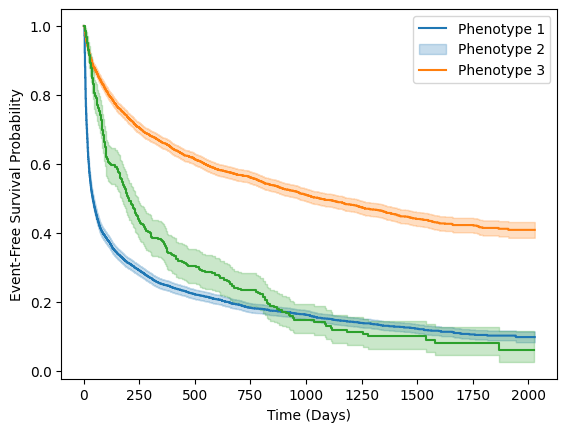

In [ ]:
# 从 auton_survival 包中导入 reporting 模块，用于生存分析绘图
from auton_survival import reporting
# 导入 matplotlib.pyplot 并简写为 plt，用于绘图
import matplotlib.pyplot as plt

# 使用 Kaplan-Meier 估计器，根据 outcomes 数据中对应 x_tr.index 的行，绘制不同表型（phenotypes）的无事件生存概率曲线
reporting.plot_kaplanmeier(outcomes.loc[x_tr.index], phenotypes)

# 设置 x 轴标签为“时间（天）”
plt.xlabel('Time (Days)')
# 设置 y 轴标签为“无事件生存概率”
plt.ylabel('Event-Free Survival Probability')
# 添加图例，分别对应三种表型，位置在右上角
plt.legend(['Phenotype 1', 'Phenotype 2', 'Phenotype 3'], loc="upper right")
# 显示绘制好的图形
plt.show()

相交的生存率表明 SUPPORT 数据集遵循非比例风险，这违反了 Cox 模型的假设。

<a id="superphenopur"></a>
### 4.4. Evaluating Phenotype Purity

为了衡量一个表型分析器提取具有不同生存率亚群的能力，我们在每个表型组内拟合 Kaplan-Meier 估计器，并利用它来估计该组内的生存率，从而估算（综合）Brier 评分。我们将此称为 *表型纯度（phenotyping purity）*。


In [ ]:
# 从 auton_survival 库导入用于计算表型纯度的函数
from auton_survival.metrics import phenotype_purity

# 调用 phenotype_purity 函数，计算在 1 年、2 年和 5 年事件时间点的表型纯度
# phenotypes_train: 训练集的表型标签
# outcomes_train: 训练集的真实结局（如生存状态）
# phenotypes_test 和 outcomes_test 设为 None，表示仅使用训练集进行评估
# strategy='instantaneous': 使用瞬时策略计算纯度
# horizons=[365, 730, 1825]: 分别对应 1 年、2 年、5 天的天数
# bootstrap=None: 不使用自助法进行置信区间估计
metric = phenotype_purity(phenotypes_train=phenotypes, outcomes_train=y_tr, 
                                phenotypes_test=None, outcomes_test=None,
                                strategy='instantaneous', horizons=[365, 730, 1825], 
                                bootstrap=None)

# 打印输出各时间点的表型纯度值，依次对应 1 年、2 年、5 年
print(f'Phenotyping purity for event horizon of 1 year: {metric[0]} | 2 years: {metric[1]} | 5 years: {metric[2]}')

Phenotyping purity for event horizon of 1 year: 0.2067628612157574 | 2 years: 0.19742473221635654 | 5 years: 0.16126177556531385


d:\Analysis\Anaconda3\envs\auton_survival\lib\site-packages\auton_survival\metrics.py:334: UserWarning: You are are estimating survival probabilities for the same dataset used to estimate the censoring distribution.
  warnings.warn("You are are estimating survival probabilities for \
d:\Analysis\Anaconda3\envs\auton_survival\lib\site-packages\lifelines\fitters\__init__.py:204: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
d:\Analysis\Anaconda3\envs\auton_survival\lib\site-packages\lifelines\fitters\__init__.py:204: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
d:\Analysis\Anaconda3\envs\auton_survival\lib\site-packages\lifelines\fitters\__init__.py:204: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using l

可以观察到，监督表型分析的表型纯度低于非监督表型分析。这表明，监督表型分析器在观察到的生存率方面能够提取出具有更高区分能力的表型组。

*重要提示：表型纯度只能在识别出相同数量亚组的表型分析器之间进行比较。这是因为提取亚组数量多于其他分析器的表型分析器本身会具有更好的表型纯度。*


<a id="counterpheno"></a>
## 5. Counterfactual Phenotyping

*For examples of counterfactual phenotyping with Deep Cox Mixtures with Heterogeneous Effects (CMHE) [1], please refer to the following paper and example jupyter notebook*:

[1] [Counterfactual Phenotyping with Censored Time-to-Events, arXiv preprint, C. Nagpal, M. Goswami, K. Dufendach, A. Dubrawski](https://arxiv.org/abs/2202.11089)

[Demo of CMHE on Synthetic Data.ipynb](https://github.com/autonlab/auton-survival/blob/master/examples/Demo%20of%20CMHE%20on%20Synthetic%20Data.ipynb)